In [ ]:
# Thoghts
# Add more pretrained networks
# Use additional data such as define an item as number od images:
# - run each network over every image and decide using weighting voting 
#   using softmax probability output) to decide  
# - Give a weight to each image in an item using prior knowledge - for example if the first image is usually
#   the most important etc.
# - Novel architecture - run each image of an item over some or all conv/relu/pooling layers,
#   then concat output and add additional fully connected layers and get one category output per item
#   * This will probably involve some 1X1 conv to decrease dimensonality as the first fully connected
#     will be extremly large
# - Use bigger size for input images or original size with average pooling (fc constraints input size)

In [7]:
# Assumptions:
# Multi-class problem (and not Multi label)
# I used every image independently and didn't added the item correlation. The easiest and fastest way
# to add this prior knowledge is by voting all outputs for each unique item 
# though there are 11000 training exam, I succeeded fetching only 10000, didn't bother me that much as
# it was equally seperated between the classes

# - I've neglected ad index as (assumption above)
# - As I work with Keras it was easier for me for me to copy all images and set them in unique folders
#   for each class  For viszualization purposes

# Phases:
# - Set images in dirs by categories
# - Examine - 
# * High imbalance dataset!!! options - augment a lot most of the data, use weighted loss
# * Trained again with weighted loss
# * Specifically, some classes are strongly related to others. It'll surely increase accuracy by merging
#   categories and first classify shoes,jewlery,cosmetics,Accessories,watches and clothing.
#   Then we can go deeper to each sub category - one classifier for shoes and wedding shoes,
#   and one classifier for clothing,maternity clothong, wedding suits and wedding dresses.  
#   This will help in the imbalance problem in an order of magnitude, for other orders it will be best
#   to augment more samples from low classes
# * better to first merge these classes and then classiffy solely between shoes and wedding shoes 
# - Resize to 224*224 (vgg constraint) and examine if sufficient (it will be seen by the results ),
#   Keep aspect ratio by padding with zeros in image borders
#   preprocess as in vgg(subtract mean)
# - Train Val split - 8732 train and 1500 validation
# - augmentation
#  * did mirroring, shift and zoom. didn't did rotation as I assume this will ruin the inner structure
#   of the data. It's possible to also use luminance changes (convert images to lab space) . augment 2X images
# - Examine
# - Decide a method to work - because no prior knowledge and time to extract features - obviously cnn's
#  * Imagenet for the rescue, I used VGG19 due to it's simplicity of structure and proven results.
#   With more time I would also try Resnet50 
# - Only finetune (not enought data and natural images)
# - Start drilling trainable 
# - Simple fine tune for last layer didn't yield
# - Drill in in trainable layers to see where overfit is inevitable, I got that training any convolution
#   layer provides a big overfit, So I trained only my addition for the network
# - Random search over parameter space (log space) for one epoch
#   Chose best hyper-parameter and trained - reached 83% on validation, high imbalance
#   By examining conf matrix one can see problem of imbalance. Learning curves was hard to  
#   investigate due the fact that networked converged pretty quickly, with more data it would be an option.
#   Data learning curve could have been nice but there wasn't an option to add more data so I didn't compute
#   Used weighted loss - though improving as expected the precision and recall (write what they are)
# - Choose best hyper-parameter set and fully train over full training data (10500)
#   It didn't improve the accuracy so I preffered to stick with the balanced loss model.
# - Train over all training data

In [1]:
# Import modules 
from scripts.dataset import Dataset
from scripts.classification_model import Classification_model
from scripts.classification_model import Hyper_params,Lr,Lr_reduce_on_plateau,Early_stop,Learning_params
from scripts.model_evaluator import Model_evaluator
from scripts import classifier_utils
from time import gmtime, strftime
from random import uniform
import sys
import os
import tensorflow as tf
from keras import backend as K
import keras.backend.tensorflow_backend as KTF
import numpy as np


def get_session(gpu_fraction=0.8):
    'Allocate gpu_fraction its memory for computattion'

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())
tf.GraphKeys.VARIABLES = tf.GraphKeys.GLOBAL_VARIABLES
cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())

# This code supports tensorflow backend only
assert K.image_dim_ordering() == 'tf'

Using TensorFlow backend.


In [2]:
data_dir = 'data'
train_file = 'train_dataset.txt'
test_dir = 'test'
test_file = 'test_dataset.txt'
CLASS_NAMES = ['1521','1703','1707','1729','1751','1755','1837','2037','2525','2526']
PRETRAINED_MODEL = 'VGG19' #TODO: check using Resnet 50

In [4]:
# # # May run this this one time only

## Copy images to data dir where each class images are in a specific folder 
classifier_utils.copy_images_to_class_dirs(train_file, data_dir, CLASS_NAMES)

# # Split data to train val
classifier_utils.resize_and_train_val_split(data_dir, CLASS_NAMES)

['1521', '1703', '1707', '1729', '1751', '1755', '1837', '2037', '2525', '2526']
resizing images
data/1521
pre-processingdata/1521 dir
data/1703
pre-processingdata/1703 dir
data/1707
pre-processingdata/1707 dir
data/1729
pre-processingdata/1729 dir
data/1751
pre-processingdata/1751 dir
data/1755
pre-processingdata/1755 dir
data/1837
pre-processingdata/1837 dir
data/2037
pre-processingdata/2037 dir
data/2525
pre-processingdata/2525 dir
data/2526
pre-processingdata/2526 dir
data/train/1521 created
data/train/1703 created
data/train/1707 created
data/train/1729 created
data/train/1751 created
data/train/1755 created
data/train/1837 created
data/train/2037 created
data/train/2525 created
data/train/2526 created
data/val/1521 created
data/val/1703 created
data/val/1707 created
data/val/1729 created
data/val/1751 created
data/val/1755 created
data/val/1837 created
data/val/2037 created
data/val/2525 created
data/val/2526 created


In [4]:
# Create experiment dirs (weights, summary)
[experiments_dir, model_dir, weights_dir, summary_dir] = classifier_utils.create_experiment_directories()

print 'Creating train dataset'
train_dataset = Dataset(data_dir,'train', PRETRAINED_MODEL,
                        class_names=CLASS_NAMES,
                        augment_factor=2.0, fliplr=True,
                        shift_range=0.2, zoom_range=0.2)
print 'Creating val dataset'
val_dataset = Dataset(data_dir,'val', PRETRAINED_MODEL,
                        class_names=CLASS_NAMES)

# Init params for first time - initial guess
#Hyperparams
hyper_params = Hyper_params(lr=Lr(init=0.0001,decay=0.0), optimization_method='Adam',
                           momentum=0.9, weight_decay=0.0002, dropout_rate=0.35,
                           freeze_layer_id=21, architecture_head_type='no_layers',
                           is_use_batch_normalization=True, nb_filters_conv_1_1_first=128,
                           nb_filters_conv_1_1_second=32, fc_layer_size_1=128, fc_layer_size_2=64)
#Learning params
learning_params = Learning_params(nb_train_samples=train_dataset.nb_samples,
                                 nb_validation_samples=val_dataset.nb_samples,
                                 batch_size=32, nb_max_epoch=150, 
                                 nb_samples_per_epoch=train_dataset.nb_samples ,
                                 nb_validation_samples_per_epoch=val_dataset.nb_samples,
                                 ckpt_period=1, early_stop=Early_stop(is_use=True, min_delta=0.005,patience=15),
                                 lr_reduce_on_plateau=Lr_reduce_on_plateau(is_use=True, factor=0.5, min_lr=1e-08, patience=3))
# Init classification model
clf_model = Classification_model(train_dataset.nb_classes,
                 weights_dir, summary_dir,
                 'VGG19',False)


Creating train dataset
data/train
10 Classes detected:
['1521', '1703', '1707', '1729', '1751', '1755', '1837', '2037', '2525', '2526']
Loading 8698 unique images from data/train/ directory
Found 8698 images belonging to 10 classes.
loaded and augmented all images
train shape: (17396, 224, 224, 3)
Creating val dataset
data/val
10 Classes detected:
['1521', '1703', '1707', '1729', '1751', '1755', '1837', '2037', '2525', '2526']
Loading 1601 unique images from data/val/ directory
Found 1601 images belonging to 10 classes.
loaded and augmented all images
train shape: (1601, 224, 224, 3)
loading vgg 19 network
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
___________________________________________________________________________________

In [22]:
# # # Hyper-Parameter search - don't run if not tuning, takes a lot of time !!

# TODO: add iteration over network, augmentation on luminance, iteration over different augmentation factors


# Iterate over hyperparameter space - currently only vgg19
# hyperparams to iterate: head_type,# nb_filters_conv_1_1_first, nb_filters_conv_1_1_second, fc_layer_size_1,
# fc_layer_size_2, freeze_layer, learning rate, weight decay,dropout_rate, batch size, 
# Init hyperparams and learning params with relevant values
# run model - low number of epochs (1)
# calc scores
# print changed value only, and scores


## Wasn't feasible on my machine to run over all hyper parameters, so by try and error I chose some of them and 
## and tuned the rest
# head_type_opts = ['no_layers', 'one_fc_layer']
# nb_filters_conv_1_1_first_opts = [16,32,64,128,256]
# nb_filters_conv_1_1_second_opts = [8,16,32,64,128]
# fc_layer_size_1_opts = [32,64,128,256,512,1024]
# fc_layer_size_2_opts = [16,32,64,128,256,512]
freeze_layer_id_opts = [20,21]#for resnet need to edit to last layers
batch_size_opts = [16,32]

max_clf_acc = 0.0
max_clf_hyper_params = Hyper_params()
max_clf_learning_params = Learning_params()

learning_params.nb_max_epoch = 1 # restrict num epochs per test
is_save_ckpts = False

num_options = 2*2*3*3*3
count = 0
for freeze_layer_id in freeze_layer_id_opts:
    hyper_params.freeze_layer_id = freeze_layer_id
    for batch_size in batch_size_opts:        
        for i in range(0,3):
            for j in range(0,3):
                for k in range(0,3):                     
                    learning_rate = 10**uniform(-6,-1)
                    hyper_params.lr.init = learning_rate
                    weight_decay = 10**uniform(-6,0)
                    hyper_params.weight_decay = weight_decay
                    dropout_rate = uniform(0,1)
                    hyper_params.dropout_rate = dropout_rate
                   
                    print '\n\n'    
                    learning_params.batch_size = batch_size
                    print 'freeze_layer_id: ' + str(freeze_layer_id)
                    print 'learning_rate: ' + str(learning_rate)
                    print 'weight_decay: ' + str(weight_decay)
                    print 'dropout_rate: ' + str(dropout_rate)
                    print 'batch_size: ' + str(batch_size) +'\n'
                    count = count + 1
                    print 'processing option number ' + str(count) + ' out of ' + str(num_options)                                                            
                    clf_model.build_model(input_shape=train_dataset.images[0,:,:,:].shape,
                                          hyper_params=hyper_params)      
                    clf_model.compile_model(learning_params, is_save_ckpts)
                    clf_model.train(train_data=train_dataset.images,train_labels=train_dataset.labels,
                            validation_data=val_dataset.images, validation_labels=val_dataset.labels)
                    clf_model_evaluator = Model_evaluator(clf_model, train_dataset.class_names)
                    clf_score = clf_model_evaluator.get_classifier_score(dataset=val_dataset)
                    if clf_score[1] > max_clf_acc:
                        print 'max clf acc found!! acc =  ' + str(clf_score[1])
                        max_clf_acc = clf_score[1]
                        max_clf_hyper_params = hyper_params
                        max_clf_learning_params = learning_params
                    clf_model.delete_model()

0 image_input
1 vgg19
2 bottlekneck_1_1_conv_1
3 batch_norm_1
4 bottlekneck_1_1_conv_2
5 batch_norm_2
6 flatten
7 dropout
8 predictions
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
vgg19 (Model)                    multiple              20024384    image_input[0][0]                
____________________________________________________________________________________________________
bottlekneck_1_1_conv_1 (Convolut (None, 7, 7, 128)     65664       vgg19[1][0]                      
____________________________________________________________________________________________________
batch_norm_1 (BatchNormalization (None, 7, 7, 128)     5

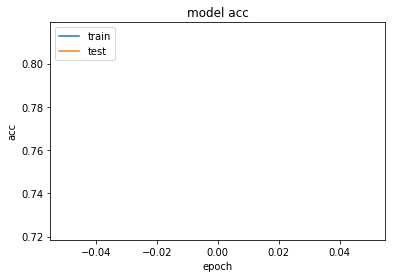

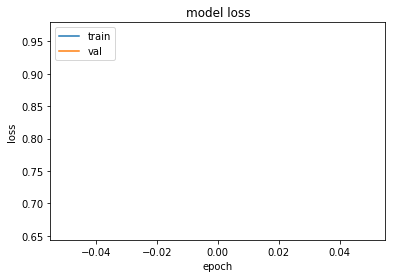

In [5]:
# Keep max clf_score set and params
# Train model again - larger number of epochs

# Load best parameter set
max_clf_learning_params = learning_params
max_clf_hyper_params = hyper_params
max_clf_hyper_params.freeze_layer_id = 21
max_clf_hyper_params.lr.init = 0.00102382988483
max_clf_hyper_params.weight_decay = 0.000173410239311
max_clf_hyper_params.dropout_rate = 0.491165771543
max_clf_learning_params.batch_size = 32

# Train over many epochs with early stop callback
learning_params.nb_max_epoch = 100 # full train on best clf found
is_save_ckpts = True

is_use_classes_weights = False
classes_weights = None
if is_use_classes_weights:
    classes_weights = train_dataset.classes_weights

clf_model.build_model(input_shape=train_dataset.images[0,:,:,:].shape,
                      hyper_params=max_clf_hyper_params)      
clf_model.compile_model(max_clf_learning_params, is_save_ckpts)
clf_model.train(train_dataset.images,train_dataset.labels,
        val_dataset.images, val_dataset.labels, classes_weights)

In [6]:
# Evaluate model
clf_model_evaluator = Model_evaluator(clf_model, train_dataset.class_names)
clf_score = clf_model_evaluator.get_classifier_score(dataset=val_dataset)
clf_model_evaluator = Model_evaluator(clf_model, train_dataset.class_names)
clf_model_evaluator.evaluate(dataset=val_dataset)

1600/1601 [============================>.] - ETA: 0sval set loss: 0.605322556225
val set accuracy: 0.826358525921
             precision    recall  f1-score   support

       1521       0.87      0.88      0.88       312
       1703       0.77      0.74      0.75        97
       1707       0.75      0.77      0.76        81
       1729       0.64      0.71      0.67       187
       1751       0.85      0.80      0.82       111
       1755       0.87      0.92      0.90       712
       1837       0.89      0.64      0.75        39
       2037       0.00      0.00      0.00        29
       2525       0.69      0.38      0.49        24
       2526       0.00      0.00      0.00         9

avg / total       0.81      0.83      0.81      1601

[[276   2   4  17   2   7   0   0   4   0]
 [  0  72   2  10   5   8   0   0   0   0]
 [  4   3  62   4   2   6   0   0   0   0]
 [ 10   7   7 132   4  27   0   0   0   0]
 [  1   4   5   7  89   5   0   0   0   0]
 [ 15   1   3  31   2 658   2   

/usr/lib/python2.7/dist-packages/sklearn/metrics/metrics.py:1905: UserWarning: The sum of true positives and false positives are equal to zero for some labels. Precision is ill defined for those labels [7 9]. The precision and recall are equal to zero for some labels. fbeta_score is ill defined for those labels [7 9]. 
  average=None)


In [7]:
## Save  best model weights to best model directory
## All check points are in experiment directory, possible to load intermediate checkpoints if overfit occured
if not os.path.exists('best_model'):
        os.makedirs('best_model')
clf_model.model.save_weights('best_model/best_weights.h5')

In [ ]:
# # # Production - Train over full training set

In [5]:
# Load data
data_dir = 'data'
data_dir = os.path.join(data_dir,'full')
is_production = True
is_save_ckpts = False

print 'creating production_train dataset'
prod_train_dataset = Dataset(data_dir,'train', PRETRAINED_MODEL,
                        class_names=CLASS_NAMES,
                        is_production = True,
                        augment_factor=2.0, fliplr=True,
                        shift_range=0.2, zoom_range=0.2)

creating production_train dataset
data/full
10 Classes detected:
['1521', '1703', '1707', '1729', '1751', '1755', '1837', '2037', '2525', '2526']
Loading 10299 unique images from data/full/ directory
Found 10299 images belonging to 10 classes.


KeyboardInterrupt: 

In [9]:
# Create and train model, start training or load from scratch from last checkpoint

# Had an unknown bug while loading and saving models, can't tell why this happened.
# This is why I init a new model and loaded weights instead of loading using json files

best_hyper_params = Hyper_params(lr=Lr(init=0.00102382988483,decay=0.0), optimization_method='Adam',
                           momentum=0.9, weight_decay=0.000173410239311, dropout_rate=0.491165771543,
                           freeze_layer_id=21, architecture_head_type='no_layers',
                           is_use_batch_normalization=True, nb_filters_conv_1_1_first=128,
                           nb_filters_conv_1_1_second=32, fc_layer_size_1=128, fc_layer_size_2=64)
best_learning_params = Learning_params(nb_train_samples=prod_train_dataset.nb_samples,
                                 batch_size=32, nb_max_epoch=150, 
                                 nb_samples_per_epoch=prod_train_dataset.nb_samples ,
                                 ckpt_period=1, early_stop=Early_stop(is_use=True, min_delta=0.005,patience=15),
                                 lr_reduce_on_plateau=Lr_reduce_on_plateau(is_use=True, factor=0.5, min_lr=1e-08, patience=3))
best_weights_dir = 'best_model'
best_summary_dir = best_weights_dir
best_model = Classification_model(10, best_weights_dir, best_summary_dir, PRETRAINED_MODEL,False)
best_model.build_model(input_shape=prod_train_dataset.images[0,:,:,:].shape,
                       hyper_params=best_hyper_params)

best_model.model.load_weights(os.path.join(best_weights_dir,'best_weights.h5'))
best_model.compile_model(best_learning_params, is_save_ckpts, is_production)
best_model.train(prod_train_dataset.images, prod_train_dataset.labels, is_production=True)

loading vgg 19 network
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 64 1792        input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64 0           block1_conv2[0][0]               
____________________________________________________________________

In [10]:
# Save production model 
best_model.model.save_weights('best_model/production_weights.h5')

In [16]:
## Generate predictions on test set


In [3]:
# Copy images to test dir 

test_images = classifier_utils.load_test_images(test_file, test_dir,PRETRAINED_MODEL)


Copying images to test dir
pre-processing test/images dir
Found 4674 images belonging to 1 classes.


In [21]:
# Predict images and save
predictions = best_model.model.predict(test_images)
out_classes = np.argmax(predictions, axis=1)
classifier_utils.generate_output_file(test_file, 'results_test.txt', out_classes, CLASS_NAMES)